# A Notebook showing 'reverse Deconvolution' a.k.a. PSF Distilling

The Point Spread Function (PSF) is a fundamental parameter for characterizing an imaging system and a required parameter for deconvolution and super-resolution imaging.  It describes how a point source is imaged.  Extracting a PSF from a single bead is sometimes not reliable because of the beads small signal level and intererence from other nearby beads.  Further the PSF can be spatially varying.  Even if using a non-varying deconvolution model it can be advantageous to use an average PSF from a field of beads instead of a single bead.  Extracting a PSF from a field of beads can be done with Fourier-based methods,  MLE methods (fitting parameters of a theoretical PSF to the bead image), or performing a reverse deconvolution (sometimes called PSF distilling).

This notebook has been developed in part to answer the below imagesc questions...

https://forum.image.sc/t/apply-astigmatism-to-a-model-psf/9768

https://forum.image.sc/t/pyme-psfextraction-creates-psfs-with-higher-than-expected-intensity-in-outer-rings/62973


In this notebook we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

The notebook shows how to create a 'true object' from a field of sub-resolution beads using the prior knowledge of the shape of the beads (a sub-resolution point).  Then use the 'true object' to find an aproximation of the PSF using a reverse deconvolution

## Flaws and approximations

The notebook has a couple of flaws.  One being it does not account for the fact that the sub-resolution beads are not necessarilly at the center of pixels.  

Secondly, the PSF distilling method has a disadvantage when compared to MLE parameter fitting, as the spatial extent of the extracted PSF may be limited by signal level.  The PSF distilling method has the advantage that it can capture PSFs for which a theoretical model is not available and/or accurate.

Thirdly if the beads are all not the same size, or if the beads are not sub-resolution, or multiple beads stick together to form beads of different sizes, the resulting PSF will be less accurate.

In addition in this notebook some preprocessing of the beads is done (such as background subtraction and filtering), which in turn effects the extracted PSF.  Extracted PSFs using reverse deconvolution are only an approximation which are useful for using with deconvolution to obtain better contrast in images.    

## Dependencies (create a decon conda environment)

In this environment we will install some tools we need for decon, this includes Jupyter noteook, opencl, fftw, clij2fft for non-circulant Richardson Lucy, devbio version of Napari for visualization, sdeconv for theoretical PSF, tnia-python XYZ projected figures in the notebook. 

    conda create --name decon-env python=3.9
    conda activate decon-env
    pip install devbio-napari
    pip install napari-sdeconv
    pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
    pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft

Mac-users may also need to install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users may also need to install this:

    conda install -c conda-forge ocl-icd-system

## Imports

In [1]:
from skimage.io import imread
from tnia.plotting.projections import show_xyz_max
from skimage.filters import threshold_otsu, threshold_local
from skimage.measure import label

## Define image set and some parameters

The data used in this notebook can be found [here](https://www.dropbox.com/sh/kyu7te2a8gsu64d/AAAXWPaf1LihgmpPg_brDm4Ga?dl=0)

'beads in agarose stack crop.tif' is courtesy of Lorenze Cangiano

'SP8_175nm_LaurentBeads_Montage_left.tif' is courtesy of Claire Mitchell

'Haase_Bead_Image1_crop.tif is courtesy of Robert Haase

In [2]:
tnia_dir = r"D:\images\tnia-python-images\\"

# dataset = 'agarose'
dataset = 'LaurentBeads'
# dataset = 'Haase'

if dataset == 'agarose':
    beads_name = r"deconvolution\beads\beads in agarose stack crop.tif"
    axial_stretch=1
elif dataset == 'LaurentBeads':
    beads_name = r"deconvolution\beads\SP8_175nm_LaurentBeads_Montage_left.tif"
    axial_stretch=10
elif dataset == 'Haase':
    beads_name = r"deconvolution\beads\Haase_Bead_Image1_crop.tif"
    axial_stretch=1

print(f"Loading {beads_name}")
print(f"axial stretch {axial_stretch}")

Loading deconvolution\beads\SP8_175nm_LaurentBeads_Montage_left.tif
axial stretch 10


## Load Image

Here I load a test image that is obviously local to my machine.  Change the path to point to a bead image on your machine.

In [3]:
im = imread(tnia_dir+beads_name)
print(f"Image shape {im.shape}")

Image shape (50, 2048, 2048)


## Preprocessing

Preprocessing may need to be tweaked for bead images of different characteristics.  In this case we perform a crude background subtraction by subtracting ```1.25*mean``` from the image and apply a median filter.

### Important Cavaet

Since the preprocessing aften has to be different between different bead input images, all preprocessing steps should be tracked in a script or notebook.  

### background subtraction

In [4]:
im=im.astype('float32')
print(im.mean())

im=im-1.25*im.mean()
im[im<=0]=.1
print(im.min(), im.max(), im.mean())

3.7590055
0.1 4090.3013 3.4638512


### median filter

In [5]:
from skimage.filters import median
from skimage.morphology import cube
im = median(im, cube(3))

## Visualize the bead image

In this case we use an XYZ max projection utility to take a look at the image.

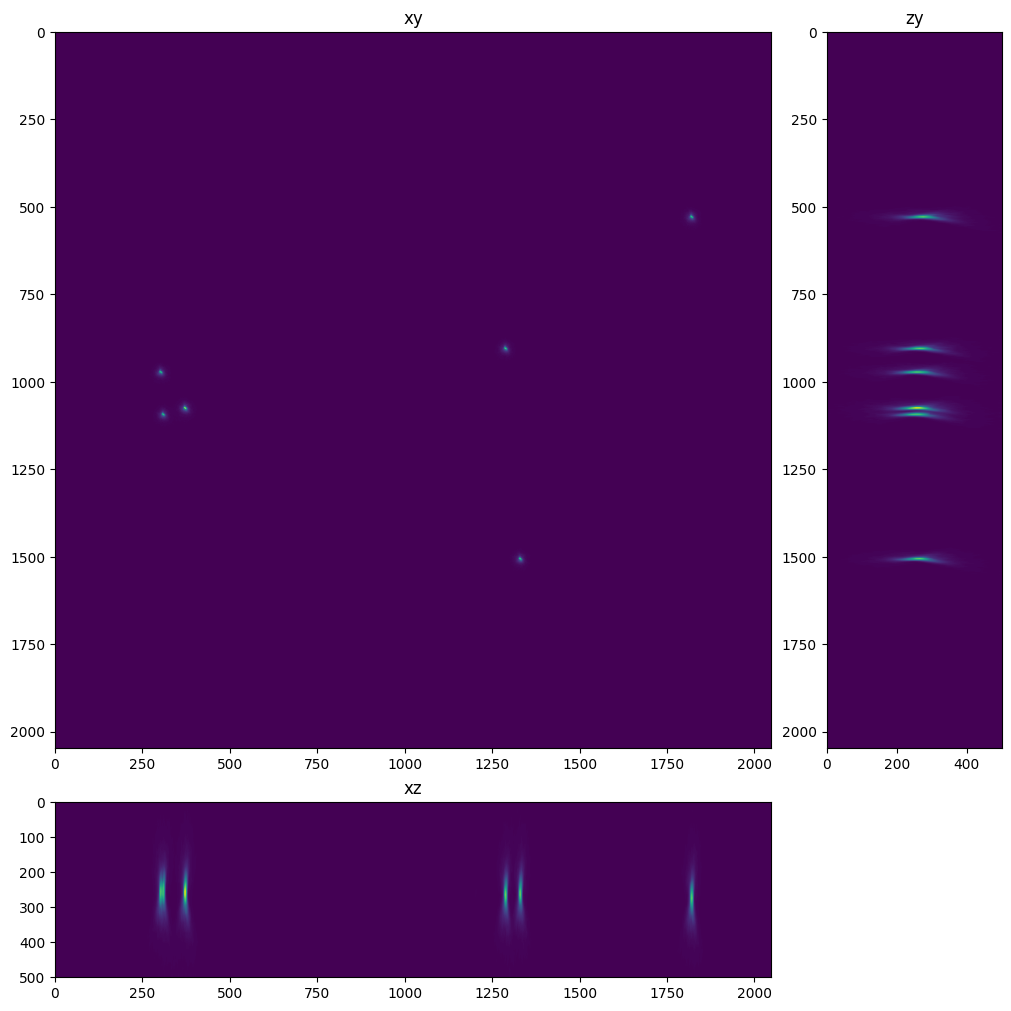

In [6]:
fig=show_xyz_max(im,1,axial_stretch)

## Threshold the beads

In this case a simple global Otsu does an alright job at thresholding the beads.  This step may need to be tweaked for images with different characteristics.

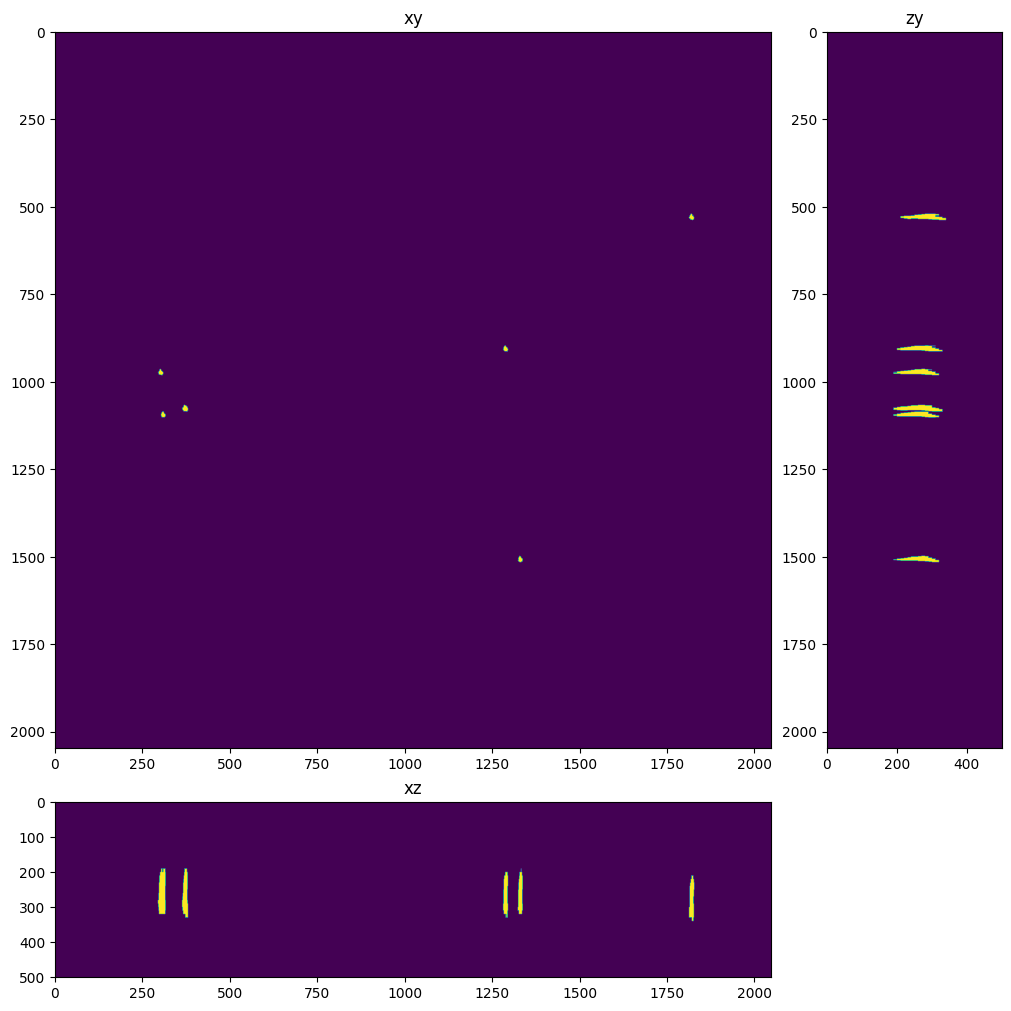

In [7]:
thresholded = im>threshold_otsu(im)
fig=show_xyz_max(thresholded,1,axial_stretch)

## Find bead centroids

In this step we create a label image, create region properties for each label so we can get the centroid of each bead.  We create an empty image and draw a point at each centroid.  This aproximates the 'true object' of the field of sub-resolution beads

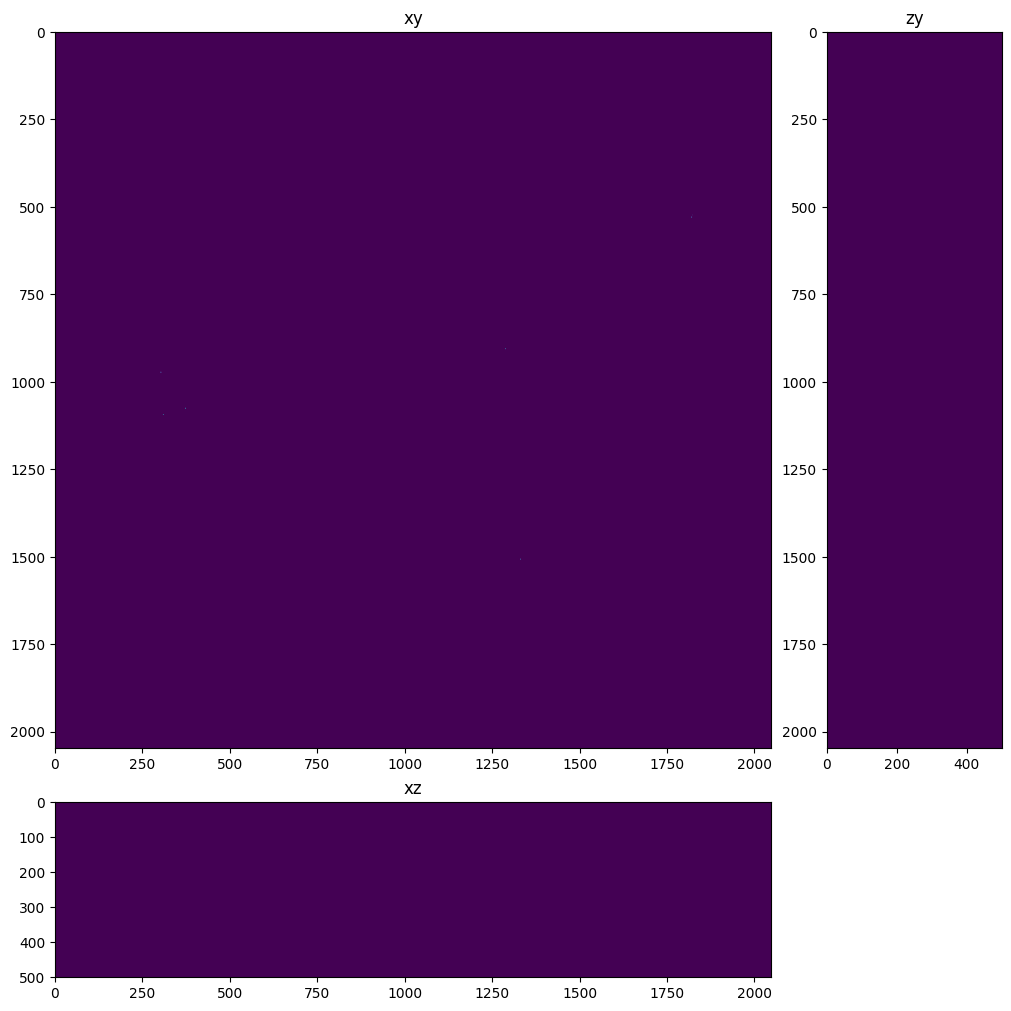

In [8]:
labels=label(thresholded)

from skimage.measure import regionprops
import numpy as np
centroids = np.zeros_like(labels)

objects = regionprops(labels)

for o in objects:
    centroids[int(o.centroid[0]),int(o.centroid[1]),int(o.centroid[2])]=im[int(o.centroid[0]),int(o.centroid[1]),int(o.centroid[2])]
fig=show_xyz_max(centroids,1,axial_stretch,vmax=centroids.max()/3)

# Note drawing centroids is wrapped in the below convenience method
# from tnia.segmentation.rendering import draw_centroids
# centroids = draw_centroids(thresholded)

## Aproximate PSF using 'reverse Deconvolution' a.k.a. PSF Distilling

In this step we perform a reverse deconvolution to solve for the PSF.  The acquired image is the convolution of a PSF and a 'true object'.  The 'true object' is the deconvolution of the image using the PSF.  However if we know the true object (in this case a field of sub-resolution beads) we can reverse the role of object and PSF, and solve for the PSF
```
Image=convolution(object,psf)

object=deconvolution(image,psf)

psf=deconvolution(image,object)
```

We use clij to perform the Richardson Lucy deconvolution however any implementation of Richardson Lucy deconvolution could be used at this step

In [10]:
platform = 'tnia-cupy' # or 'clij2fft'

if platform == 'tnia-cupy':
    from tnia.deconvolution.richardson_lucy import richardson_lucy_cp as richardson_lucy;
elif platform == 'clij2fft':
    from clij2fft.richardson_lucy import richardson_lucy

im_32=im.astype('float32')
centroids_32=centroids.astype('float32')
first_guess=np.ones_like(im_32)
psf=richardson_lucy(im_32, centroids_32, 300)#, first_guess=first_guess)
psf_cropped=psf

c:\Users\bnort\miniconda3\envs\decon_bioformats\lib\site-packages\cupy\_environment.py:440: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''



0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 


## Inspect PSF Image 

Below we visualize the PSF image and the intensity enhanced PSF image.  In the intensity enhanced PSF Image artifacts are apparent.  Note the dim reflections of the PSF, and also note the limited spatial extent of the intensities.  

Text(0.5, 0.98, 'PSF intensity enhanced')

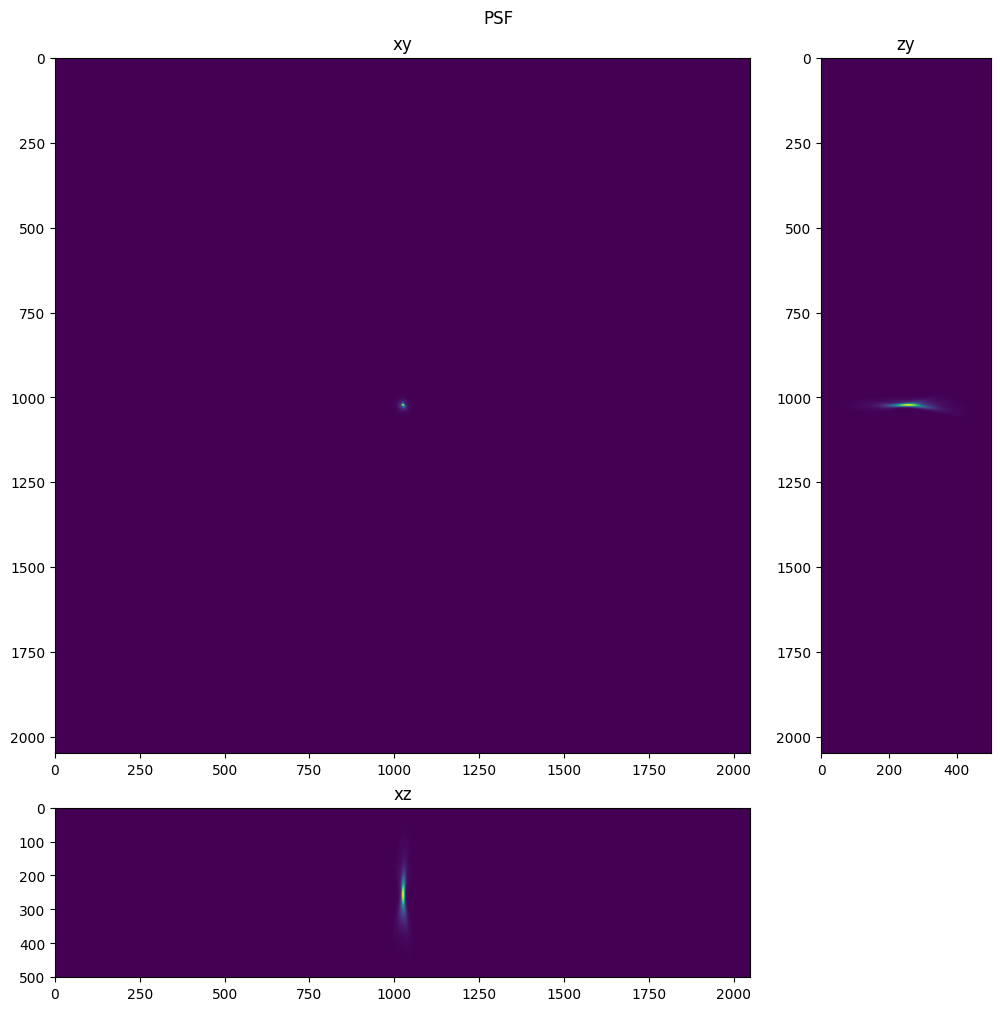

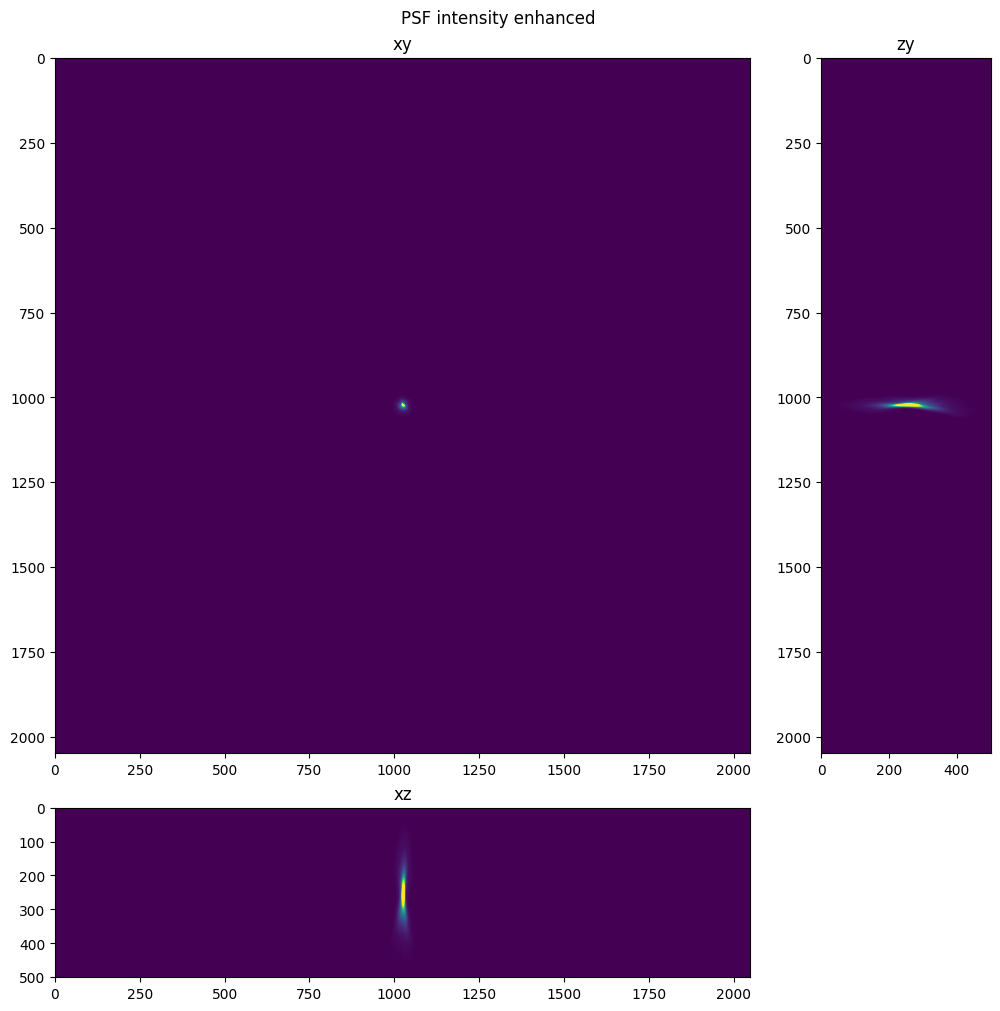

In [11]:

fig = show_xyz_max(psf,1,axial_stretch)
fig.suptitle('PSF')
fig = show_xyz_max(psf,1,axial_stretch,vmax=psf.max()/2, gamma=0.4)
fig.suptitle('PSF intensity enhanced')

## Post-processing of PSF

Low intensity values and values far away from the center of the PSF may not contain useful information about the PSF, so crop the PSF and set low intensities to zero via subtraction and setting negative values to zero.  Note this results in a spatially truncated PSF.  We did not reliably reconstruct low intensity values far away from the center.  

Also note the background level is a simple and somewhat arbitrary estimate (psf max divided by 500).  More sophisticated background subtraction approaches could be better.

This PSF, when used with deconvolution will still produce images with enhanced contrast and less blur, however we should be aware of the limitation especially for images with large bright objects that cause blur with large spatial extent.

Text(0.5, 0.98, 'PSF background subtracted and normalized')

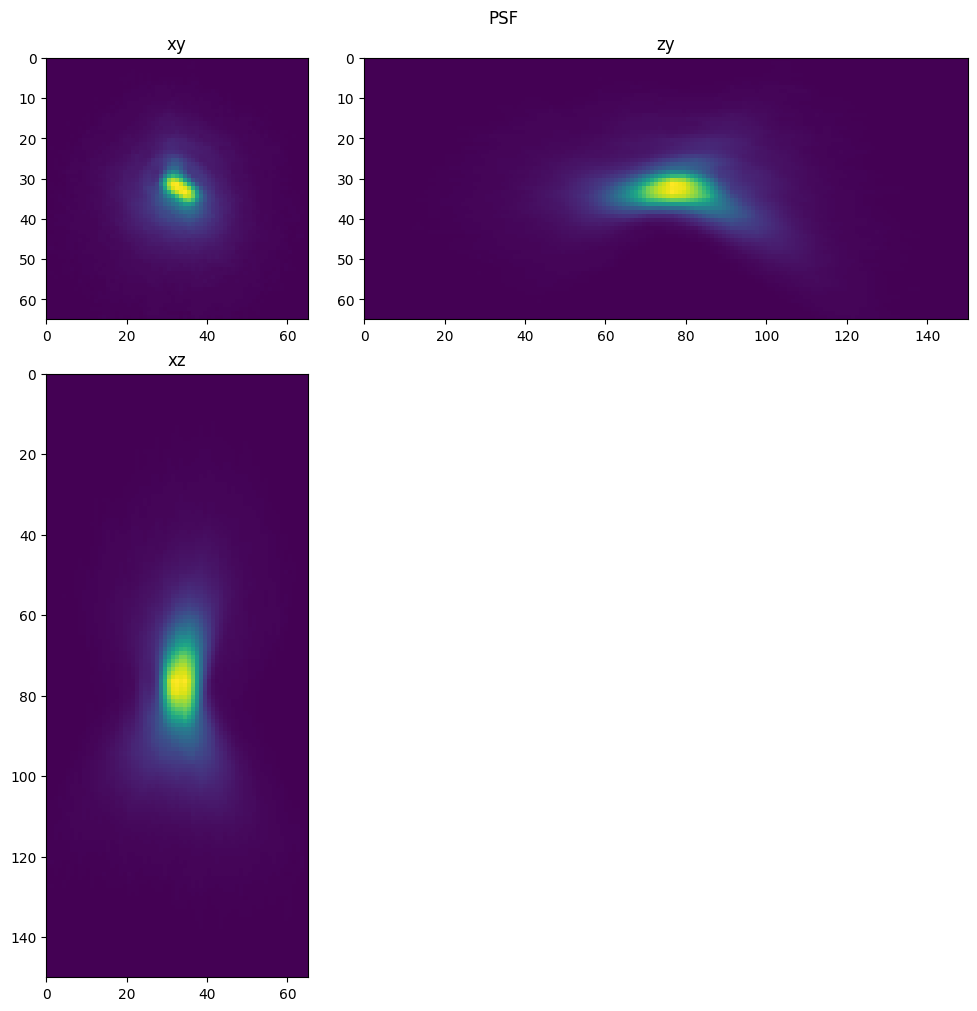

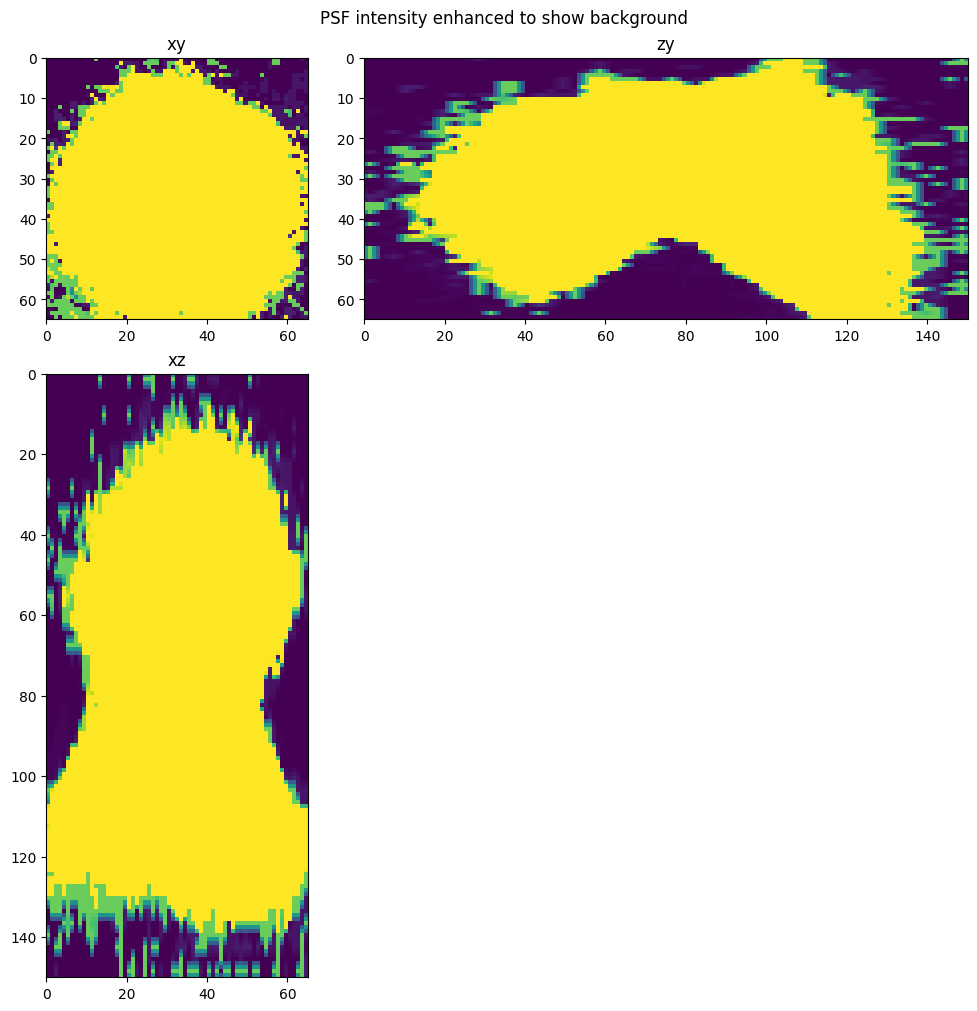

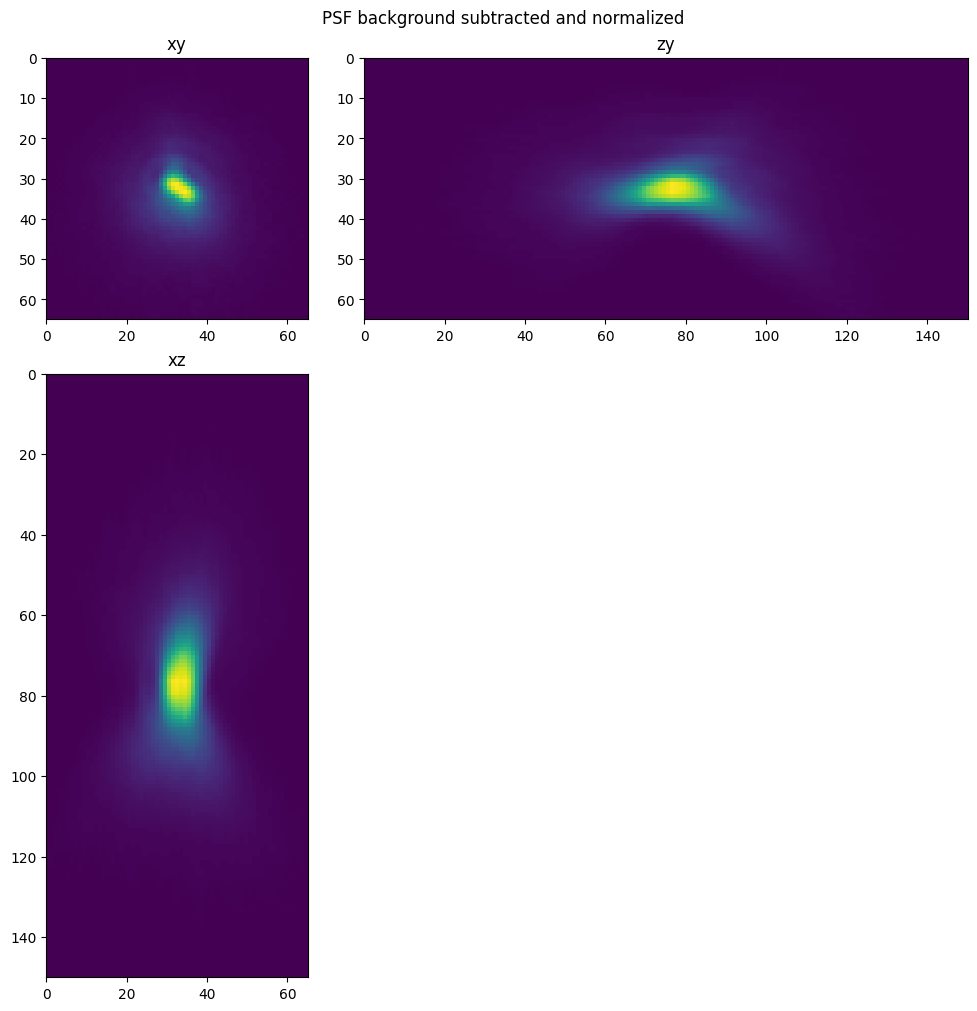

In [12]:
from tnia.nd.ndutil import centercrop
psf_= centercrop(psf, (50,65,65))

# note after cropping we change the axial stretch back to 3 as the xy dimensions are smaller so we don't need as much stretch to visualize the axial dimension
# (note the axial stretch does not correpsond to the actual xy to z ratio, it is just a visualization parameter)
axial_stretch=3

background = psf_.max()/500

fig = show_xyz_max(psf_,1,axial_stretch)
# set title
fig.suptitle('PSF')
fig = show_xyz_max(psf_,1,axial_stretch, vmax=background)
fig.suptitle('PSF intensity enhanced to show background')
psf_ = psf_-background
psf_[psf_<0]=0
psf_ = psf_/psf_.sum()

fig = show_xyz_max(psf_,1,axial_stretch)
fig.suptitle('PSF background subtracted and normalized')

## Test PSF by deconvolving beads

The end goal is to be to use the PSF with deconvolution, to produce images with better contrast and intensities closer to the true intensity values of the structure in the image.  

Test deconvolving the beads (this is a so-called self-prediction test, but still useful).

In [13]:
im.shape, psf_.shape

((50, 2048, 2048), (50, 65, 65))

In [14]:
from clij2fft.richardson_lucy import richardson_lucy_nc

deconvolved = richardson_lucy_nc(im, psf_, 200)
fig = show_xyz_max(deconvolved,1,axial_stretch, figsize=(10,10))
fig.suptitle('Deconvolved')
fig = show_xyz_max(deconvolved,1,axial_stretch, figsize=(10,10), gamma=0.2, vmax=deconvolved.max()/20)
fig.suptitle('Deconvolved gamma=0.2, vmax=deconvolved.max()/20')

get lib
calling convcorr 0 0


Text(0.5, 0.98, 'Deconvolved beads')

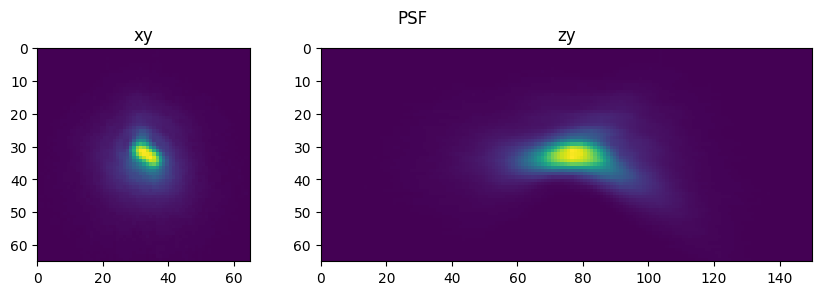

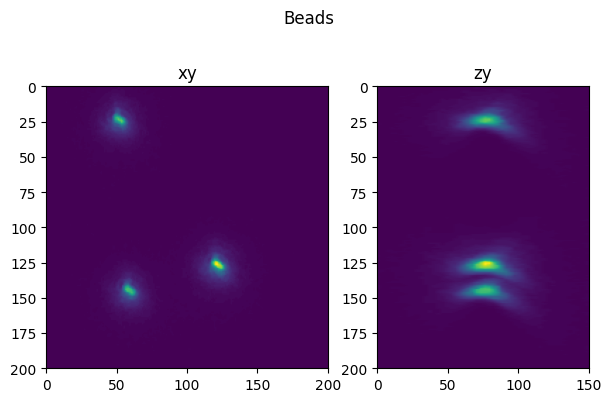

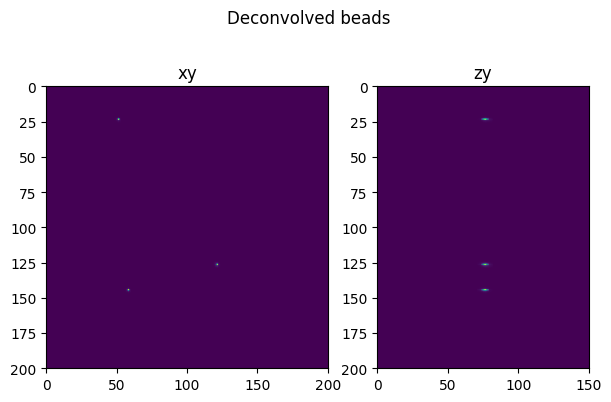

In [ ]:
from tnia.plotting.projections import show_xy_zy_max

roi = np.s_[:,950:1150,250:450]
test=im[roi]
test_deconvolved=deconvolved[roi]
axial_stretch=3

fig = show_xy_zy_max(psf_,1,axial_stretch)
fig.suptitle('PSF')
fig = show_xy_zy_max(test,1,axial_stretch, figsize=(7,4.5))
fig.suptitle('Beads')
fig = show_xy_zy_max(test_deconvolved,1,axial_stretch, figsize=(7,4.5))
fig.suptitle('Deconvolved beads')

## View in 3D

If we have napari installed we can view our PSF in 3D

In [ ]:
# start napari
import napari
viewer = napari.Viewer()

# show images
viewer.add_image(im, scale = [3,1,1])
#viewer.add_image(psf.astype('uint16'), scale = [3,1,1])
#viewer.add_image(thresholded, scale = [3,1,1])
#deconvolved2=deconvolved.astype('uint16')
viewer.add_image(deconvolved, scale = [3,1,1])

In [ ]:
# note that the above steps can be accessed from a convenience function as follows
from tnia.deconvolution.psfs import psf_from_beads
psf, im_preprocessed, centroids=psf_from_beads(im)

fig = show_xyz_max(psf)

In [ ]:
help(psf_from_beads)